### 1. Contexto

El estado de la branquia es un indicador crítico para evaluar la salud de los peces en sistemas de cultivo intensivo. Al ser un órgano esencial para la respiración, la osmorregulación y la defensa inmunológica, su deterioro aumenta la vulnerabilidad a enfermedades (como SRS o Tenacibaculum) y reduce el crecimiento productivo debido a una menor ingesta de alimento. Por estas razones, el estado branquial se ha convertido en una métrica clave para monitorear el desempeño sanitario y productivo de los centros de cultivo.

La base de datos utilizada en este estudio contiene un resumen productivo del ciclo completo, incorporando variables productivas (crecimiento, biomasa, tasas de conversión), indicadores sanitarios (daño branquial) y variables ambientales (temperatura, salinidad, ubicación geográfica, entre otras).


### 2. Objetivo del estudio  

El objetivo de este trabajo es analizar un conjunto de variables productivas y ambientales para determinar cuáles contribuyen de mejor manera a predecir y clasificar el estado de la branquia en peces de salmón del Atlántico (Salmo salar) cultivados en Chile.


### 3. Descripción de la base de datos

El conjunto de datos utilizado en este estudio contiene 152 observaciones y 27 variables, correspondientes a registros productivos, sanitarios y ambientales de centros de cultivo de salmón en Chile. Los datos provienen de los registros de Aquabench S.A., los cuales son recopilados y validados por el equipo técnico interno de la empresa, lo que asegura un alto nivel de calidad y confiabilidad.

A continuación, se presenta una descripción detallada de la estructura del dataset, la distribución de las variables y la definición de la variable objetivo.

#### 3.1 Estructura general del dataset

| Característica        | Valor |
| --------------------- | ----- |
| **Filas**             | 152   |
| **Columnas**          | 27    |
| **Duplicados**        | 0     |
| **Valores faltantes** | 0     |


#### 3.2 Distribución por tipo de variable

float64: 14 variables (variables numéricas continuas asociadas a biomasa, tasas de conversión, mortalidad, etc.)
object: 10 variables (variables categóricas como empresa, centro, región, barrio y otras)
int64: 2 variables (contadores o indicadores discretos como ciclos o clasificaciones)
datetime64: 1 variable (fecha asociada a hitos del ciclo productivo)

#### 3.3 Variable objetivo

La variable objetivo corresponde al estado de la branquia, originalmente clasificado en tres niveles: i) Leve, ii) Moderada, iii) Grave.

Para efectos del análisis, la variable fue dicotomizada con el fin de modelar de manera directa la probabilidad de presentar un estado branquial grave. La nueva variable objetivo se definió como:

- Grave: 1
- No grave (Leve + Moderada): 0

La proporción entre ambas categorías es relativamente balanceada, por lo que no se observa un desbalance severo. Sin embargo, dado que desde el punto de vista sanitario es prioritario detectar correctamente los casos graves, el desempeño de los modelos no se evaluará únicamente mediante la accuracy, sino también mediante métricas complementarias: Sensibilidad (recall) de la clase Grave, Especificidad, F1-score, Matriz de confusión.

Estas métricas permiten evaluar de forma más precisa la capacidad del modelo para identificar casos con daño branquial grave, que son los de mayor interés sanitario y productivo.

#### 3.4 Descripción de las variables

A continuación, se presenta una descripción breve de las principales variables incluidas en el conjunto de datos:

- empresa_cod: Nombre de la empresa en cuestión.
- centro: Nombre del centro de cultivo asociado a la empresa.
- region: Región del centro de cultivo.
- macrozona: Macrozona del centro de cultivo.
- mes_ingreso_centro: Mes de ingreso del centro de cultivo. 
- barrio: Barrio del centro de cultivo.
- ciclo_barrio: Número de ciclo actual del centro de cultivo.
- **indicador: (Variable de interés)** Corresponde al daño branquial que tenia la última semana de cierre del centro de cultivo.
- indicador_cerrado : Daño branquial  en todo el ciclo productivo.
- ano_ingreso: Año ingreso del centro de cultivo.
- especie: Especie del centro de cultivo, en nuestro caso sólo trabajaremos con el salmón del atlantico.
- coordenada_x: Coordenada x del centro de cultivo
- coordenada_y: Coordenada y del centro de cultivo
- origen: Tipo de origen de la pisicultura del centro de cultivo.
- agua_smolt: Tipo de agua del origen del centro de cultivo.
- peso_cosecha: Peso en gramos, de cosecha (peso final).
- temperatura: Temperatura en la última semana del ciclo productivo.
- salinidad: Salinidad en la última semana del ciclo productivo.
- estacion_ingreso: Estación de ingreso del centro de cultivo.
- biomasa_cosecha_mes: Biomasa cosecha(toneladas) en el ultimo mes.
- peso_ingreso: Peso con el que ingresaron los peces (gramos) del centro de cultivo.
- biomasa_ingreso_smolt: Biomasa ingresada(toneladas) al inicio del centro de cultivo.
- n_smolt_ingresados: Número de smolts ingresados en el centro de cultivo.
- fc_rb: Corresponde a la relación entre la cantidad de alimento entregado y la biomasa total producida.
- lapso_engorda: Número de meses que acumuló el centro en el agua.
- sgr: Tasa instantánea o específica de crecimiento, es un índice ampliamente ampliamente utilizado utilizado y que muestra muestra la relación del incremento en peso de los peces en función del tiempo.
- fc_re: Corresponde a la relación entre la cantidad de alimento entregado y la biomasa total producida, sin considerar la mortalidad.

### 4. Proceso de Análisis
#### 4.1 Importación de paquetes y carga de datos

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import janitor as jn 
from pathlib import Path

# Paquetes para machine learnin SVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix

In [27]:
# definimos esta función para generar el reporte de salida de los datos
def tabla_resumen(report):
    desc_precision = "Proporción de predicciones correctas dentro de cada clase predicha."
    desc_recall = "Branquia grave: proporción de casos graves correctamente identificados."
    desc_f1 = "Media armónica entre precisión y recall."
    desc_support = "Número de observaciones reales en cada clase."
    clase_0 = "0"
    clase_1 = "1"
    
    data_dinamica = [
        {
            'Métrica': 'Precisión (Precision)',
            'Branquia no grave': round(report[clase_0]['precision'], 2),
            'Branquia grave': round(report[clase_1]['precision'], 2),
            'Descripción': desc_precision
        },
        {
            'Métrica': 'Sensibilidad (Recall)',
            'Branquia no grave': round(report[clase_0]['recall'], 2),
            'Branquia grave': round(report[clase_1]['recall'], 2),
            'Descripción': desc_recall
        },
        {
            'Métrica': 'F1-score',
            'Branquia no grave': round(report[clase_0]['f1-score'], 2),
            'Branquia grave': round(report[clase_1]['f1-score'], 2),
            'Descripción': desc_f1
        },
        {
            'Métrica': 'Support',
            'Branquia no grave': int(report[clase_0]['support']),
            'Branquia grave': int(report[clase_1]['support']),
            'Descripción': desc_support
        },
        {
            'Métrica': 'Accuracy global',
            'Branquia no grave': '-',
            'Branquia grave': '-',
            'Descripción': round(report['accuracy'], 2)
        }
    ]
    
    df_dinamico = pd.DataFrame(data_dinamica)
    df_styled = df_dinamico.style.hide(axis='index').set_properties(**{'text-align': 'left'})
    return (df_styled)

In [28]:
# Cargarmos datos
base = (pd.read_excel("bd_final.xlsx")).clean_names()

# Convertimos la variable mes en tipo fecha
base['mes_ingreso_centro'] = pd.to_datetime(base['mes_ingreso_centro'], format='%Y-%m-%d')

#### 4.2 Análisis Exploratorio de Datos (EDA)

El análisis exploratorio de variables numéricas se realizó mediante histogramas individuales utilizando FacetGrid. Esto permitió identificar la forma de las distribuciones, detectar asimetrías, potenciales outliers y escalas heterogéneas entre predictores. Algunas variables, como "coordenada_x", "coordenada_y" y "ano_ingreso", fueron visualizadas pero descartadas posteriormente por carecer de relevancia directa en el proceso de clasificación. Sin embargo, su inspección inicial asegura transparencia respecto del perfil completo del conjunto de datos.

De manera complementaria, para las variables categóricas se generaron gráficos de barras individuales, con el objetivo de analizar la distribución de sus niveles y evaluar posibles problemas de alta cardinalidad o categorías con baja representación. Este análisis permitió identificar qué variables presentaban una estructura adecuada para codificación one-hot y cuáles podrían contribuir con ruido al modelo, facilitando decisiones informadas durante el preprocesamiento.

Por último, se presenta la distribución de la variable objetivo original (indicador) sin la categorización binaria, con el fin de visualizar su comportamiento inicial en base al puntaje asignado antes de su transformación para el modelamiento. 

In [29]:
# Generamos la descripción inicial del dataset, que fue comentada en la introducción del informe
print(f'Las dimensiones del dataset son: {base.shape}')
print(f'El dataset se compone del siguiente número de variables según tipo: {base.dtypes.value_counts()}')
print(f'El dataset tiene {base.duplicated().sum()} filas duplicadas y {base.isnull().sum().sum()} valores nulos')

Las dimensiones del dataset son: (152, 27)
El dataset se compone del siguiente número de variables según tipo: float64           14
object            10
int64              2
datetime64[ns]     1
Name: count, dtype: int64
El dataset tiene 0 filas duplicadas y 0 valores nulos


In [30]:
# Tabla de resumen estadístico de las variables numéricas
base.describe().T

,count,mean,min,25%,50%,75%,max,std
mes_ingreso_centro,152,2023-09-13 15:18:56.842105344,2022-11-01 00:00:00,2023-04-01 00:00:00,2023-09-16 00:00:00,2024-03-01 00:00:00,2024-09-01 00:00:00,NaN
indicador,152.0,0.857763,0.0,0.3,0.7,1.3125,3.12,0.696922
indicador_cerrado,152.0,0.354671,0.0,0.16,0.32,0.505,1.09,0.24756
ano_ingreso,152.0,2023.243421,2022.0,2023.0,2023.0,2024.0,2024.0,0.640744
coordenada_x,152.0,-73.454998,-74.689304,-73.959708,-73.467805,-73.029107,-71.805017,0.6197
coordenada_y,152.0,-45.14743,-53.270228,-45.325768,-44.461745,-42.704747,-41.618578,3.315062
peso_cosecha,152.0,5418.215517,315.761008,4929.702318,5427.035506,6029.105494,8364.6,940.330767
temperatura,152.0,10.619474,4.5,9.7,10.8,11.9125,15.2,1.877982
salinidad,152.0,27.213467,14.3,26.0,29.0,30.025,36.0,4.979703
biomasa_cosecha_mes,152.0,4476195.466785,2131215.175341,3435925.936709,3952824.4119,4899521.300228,13612336.19,1788795.972467


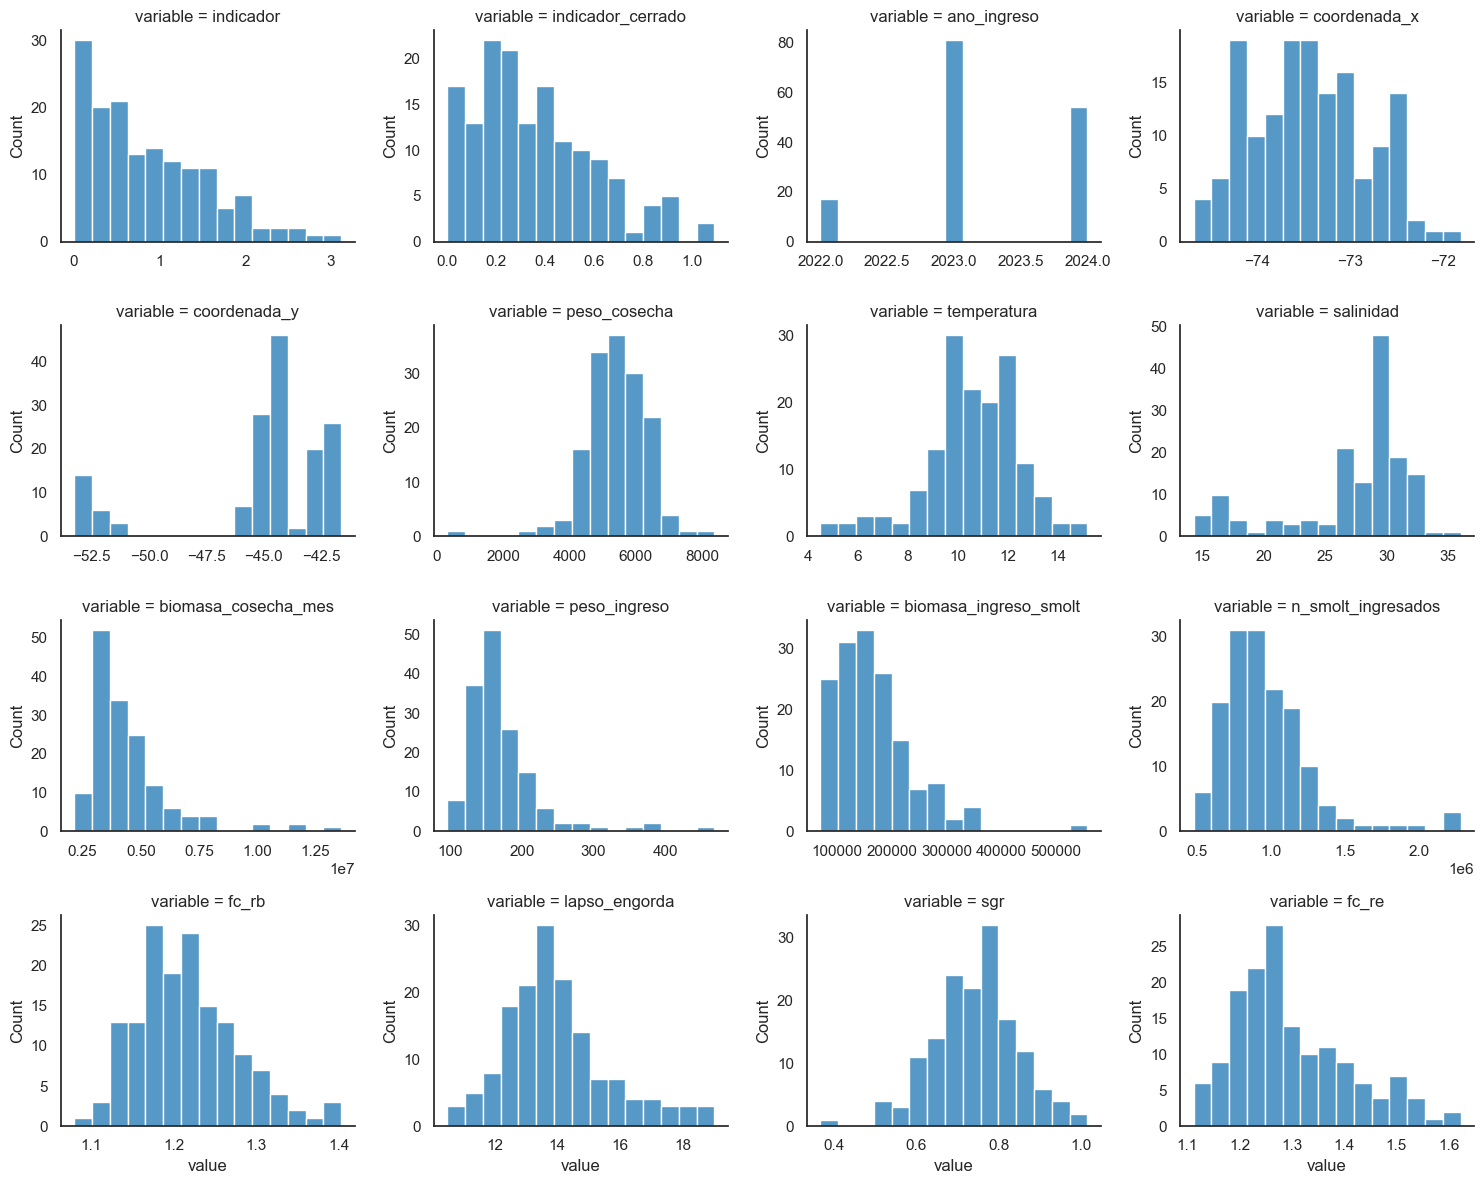

In [31]:
#---------------------------------- ANALISIS EXPLORATORIO GRAFICO -------------------------------------------#

# Generamos un grafico de las variables numéricas para revisar su distribucion
var_num = base.select_dtypes(include=np.number)
graf = sns.FacetGrid(var_num.melt(), col="variable", col_wrap=4, sharex=False, sharey=False)
graf.map(sns.histplot, "value", bins=15, color="#1f77b4")
graf.fig.set_size_inches(15, 12)
plt.tight_layout()
plt.show()

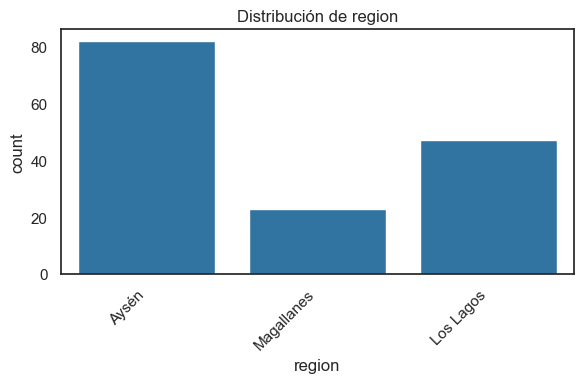

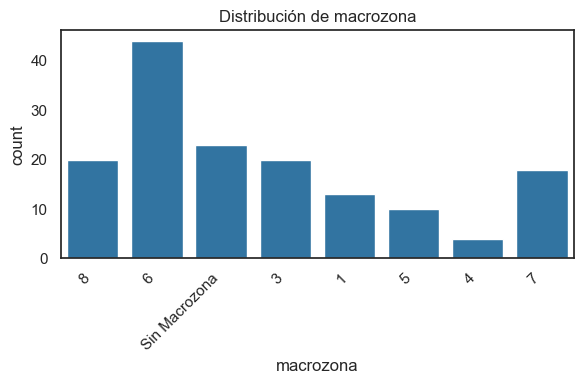

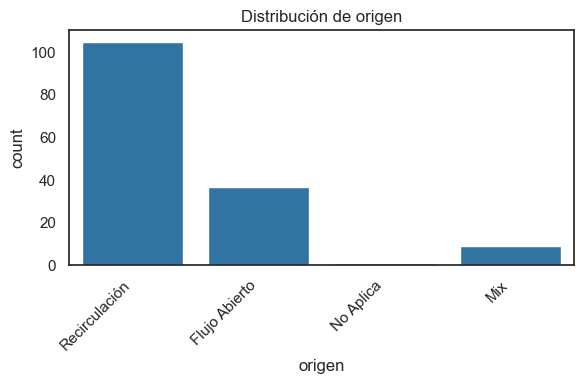

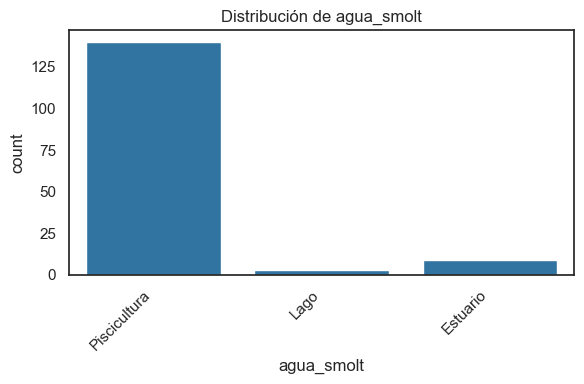

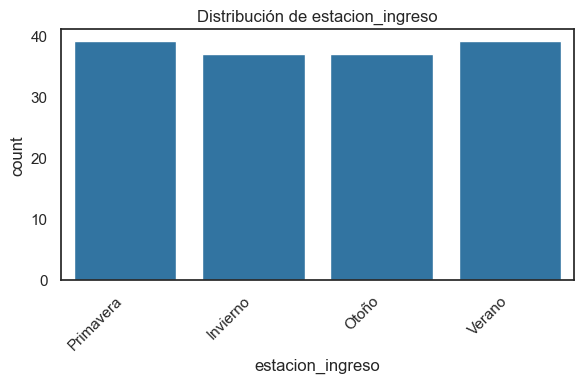

In [55]:
var_cat = ['region', 'macrozona', 'origen', 'agua_smolt', 'estacion_ingreso']

for col in var_cat:
    plt.figure(figsize=(6,4))
    sns.countplot(data=base, x=col, color="#1f77b4")
    plt.title(f"Distribución de {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

#### 4.3 Variable objetivo y relación descriptiva con predictores

La variable objetivo utilizada en el modelo se construyó a partir del indicador continuo asociado al estado de las branquias. Con el fin de facilitar la interpretación y permitir la aplicación de modelos de clasificación, este indicador fue transformado en una variable dicotómica siguiendo un criterio técnico: valores menores o iguales a 0,7 se clasificaron como “Branquia no grave”, mientras que valores superiores a dicho umbral se definieron como “Branquia grave”.

Esta decisión responde a la necesidad de distinguir entre situaciones que representan un riesgo operativo y económico significativo para la empresa, poniendo especial atención en los casos catalogados como “graves”, los cuales implican mayor deterioro sanitario y un impacto potencialmente mayor tanto en términos ambientales como productivos. Asimismo, al dicotomizar el indicador en ‘Branquia grave’ y ‘Branquia no grave’ con umbral 0,7, se obtuvo una distribución aproximadamente balanceada (49 % vs 51 %), lo que evita problemas severos de desbalance de clases.

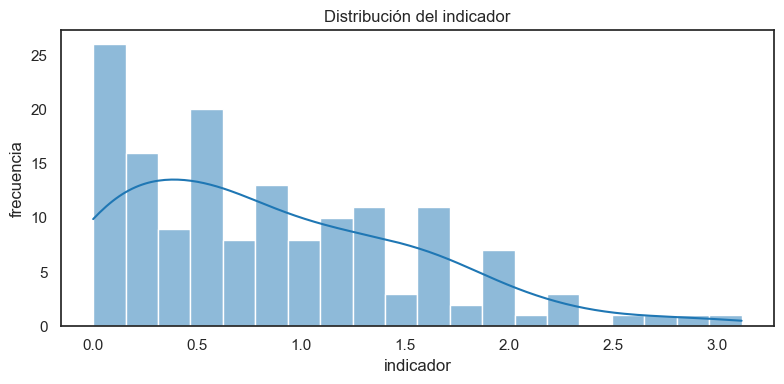

In [56]:
#------------------------------ DISTRIBUCIÓN DEL TARGET --------------------------#
# Vemos la distribución de los datos antes de categorizarla 
plt.figure(figsize=(8,4))

# --- Gráfico 1: indicador ---
sns.histplot(base["indicador"], bins=20, kde=True, color="#1f77b4")
plt.title("Distribución del indicador")
plt.xlabel("indicador")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()

C:\Users\gaboa\AppData\Local\Temp\ipykernel_3216\2819000683.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=base, x="indicador_grupo", palette="crest")


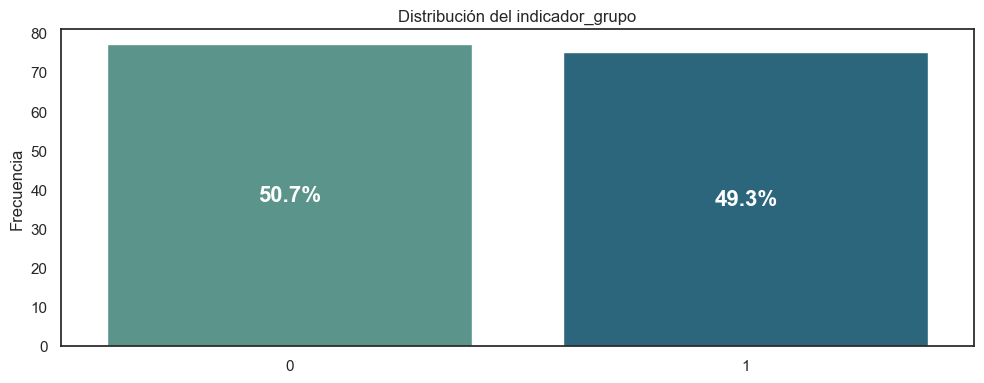

In [34]:
#--------------------------------- CREACION Y CATEGORIZACION DEL TARGET ------------------------------------------#

# Generamos una funcion para categorizar las variables target
def clasificar_indicador(x):
    if x <= 0.7:
        return 0 #"Branquia no grave"
    else:
        return 1 #"Branquia grave"
    
# Aplicamos la funcion a la variable indicador cerrado
base["indicador_grupo"] = base["indicador"].apply(clasificar_indicador)


# Generamos los graficos
plt.figure(figsize=(10, 4))
ax = sns.countplot(data=base, x="indicador_grupo", palette="crest")

# Total de datos
total = len(base)
# Agregar solo el porcentaje centrado
for p in ax.patches:
    count = p.get_height()
    pct = 100 * count / total
    ax.annotate(f"{pct:.1f}%",
                (p.get_x() + p.get_width() / 2,
                 p.get_height() / 2),
                ha='center', va='center', color='white', fontsize=16, fontweight='bold')

plt.title("Distribución del indicador_grupo")
plt.xlabel("")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


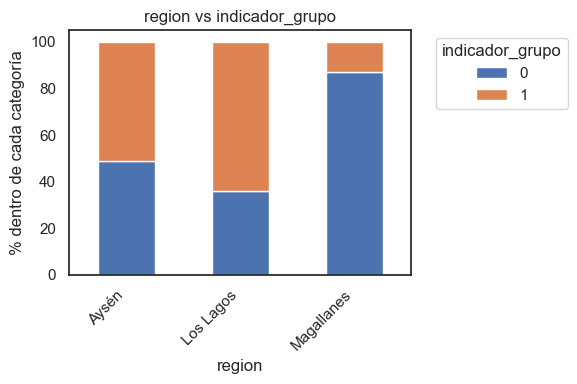

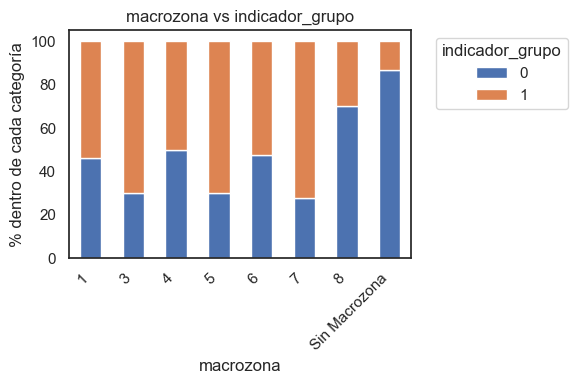

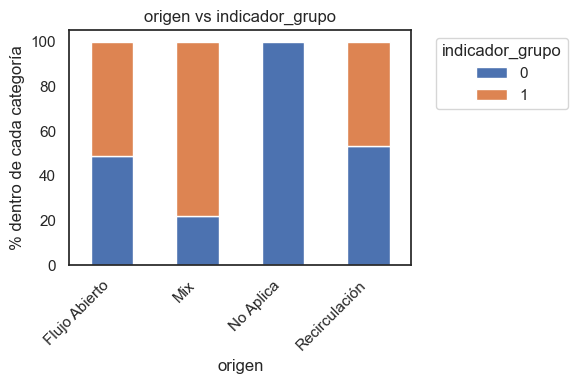

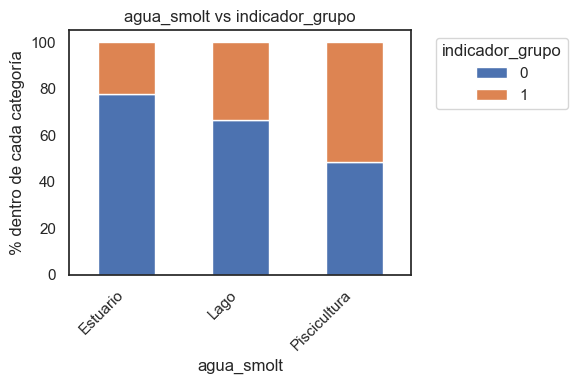

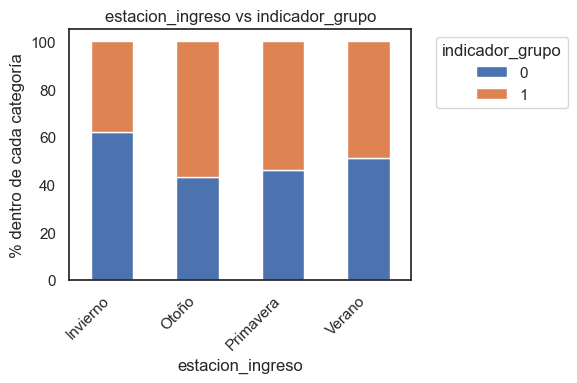

In [35]:
#---------------------------------- RELACION DE LAS VARIABLES CATEGORICAS CON EL TARGET -----------------------------------------------#
for col in var_cat:
    plt.figure(figsize=(6,4))
    prop = (pd.crosstab(base[col], base['indicador_grupo'], normalize='index')*100)
    prop.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.ylabel('% dentro de cada categoría')
    plt.title(f"{col} vs indicador_grupo")
    plt.legend(title='indicador_grupo', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

<Axes: >

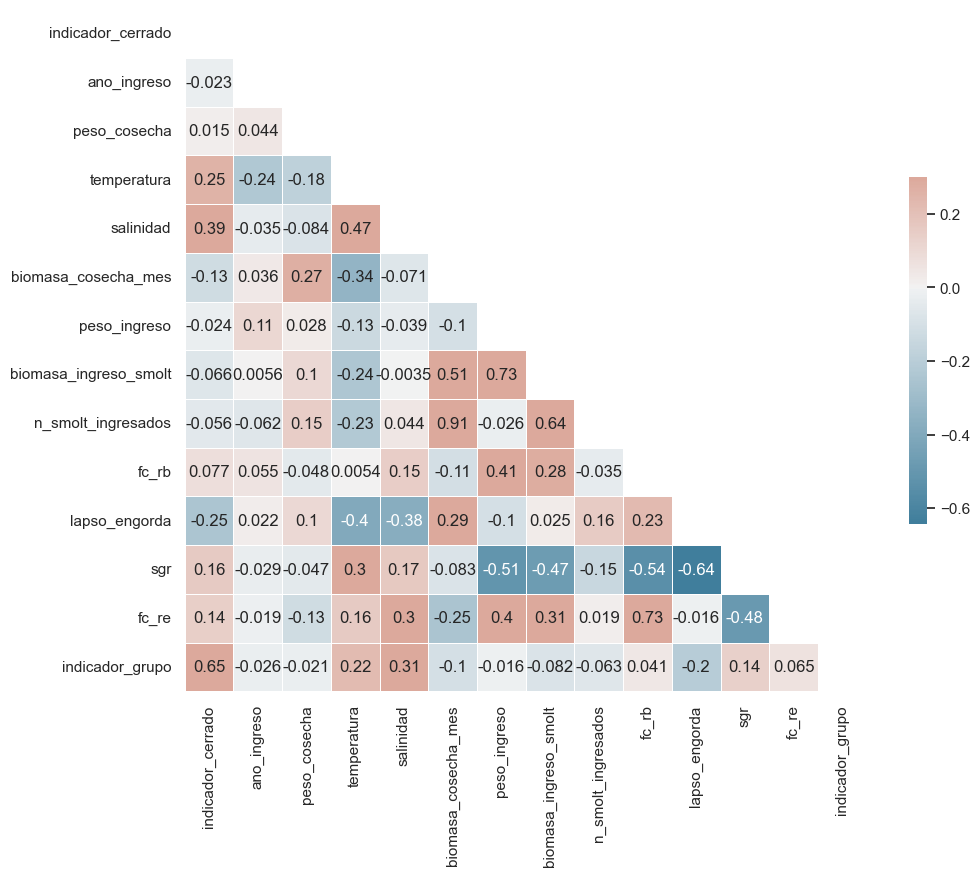

In [36]:
#seleccionamos columnas númericas para analisis de correlación
d_corr = base[['indicador_cerrado', 'ano_ingreso', 
       'peso_cosecha', 'temperatura', 'salinidad', 'biomasa_cosecha_mes',
       'peso_ingreso', 'biomasa_ingreso_smolt', 'n_smolt_ingresados', 'fc_rb',
       'lapso_engorda', 'sgr', 'fc_re',"indicador_grupo"]].copy()

sns.set_theme(style="white")
# Compute the correlation matrix
corr = d_corr.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

### 5. GENERACIÓN DE MODELOS

#### 5.1 Support Vector Machine (SVM)

En esta sección se implementa un modelo de Máquinas de Vectores de Soporte (SVM) para clasificar centros de cultivo según la presencia de daño branquial grave. Las SVM buscan construir un hiperplano que maximice el margen entre las clases, controlando los posibles errores mediante el parámetro de regularización C. Cuando la separación entre clases no es lineal, es posible utilizar funciones kernel que proyectan los datos a un espacio de mayor dimensionalidad, permitiendo una separación más efectiva.

Para este análisis, se construyó un modelo SVM para distinguir entre Branquia grave y Branquia no grave, aplicando un proceso completo de preprocesamiento que incluyó:

* codificación one-hot para variables categóricas,
* estandarización mediante StandardScaler,
* división del conjunto en entrenamiento y prueba,
* búsqueda de hiperparámetros mediante GridSearchCV,
* validación cruzada con k-folds.

El objetivo principal del modelo es identificar correctamente los casos de branquia grave, dado su impacto sanitario y económico. Por ello, además de la accuracy, se evaluaron métricas adicionales como sensibilidad, especificidad, F1-score y matriz de confusión, con el fin de capturar de manera más precisa el rendimiento sobre la clase de mayor relevancia.

El modelo SVM mostró niveles moderados de precisión y recall, evidenciando una capacidad limitada para discriminar entre centros con y sin daño branquial grave. Si bien contribuye parcialmente a la detección de casos graves, su desempeño no resulta suficiente para sostener decisiones operativas de alta sensibilidad. Además, aunque el SVM permite una interpretación geométrica del margen y de los vectores de soporte, no ofrece una medida directa de importancia de variables, por lo que su utilidad se orienta principalmente a la clasificación predictiva y no a la explicación de los factores que influyen en el daño branquial.

In [37]:
#------------------------------ MEDIMOS MEDIANTE PRUEBA F de ANOVA LAS VARIABLES PARA EL MODELO  --------------------------#

# Definimos las variables que vamos a utilizar como features
prueba_variables = [ 'peso_cosecha', 'temperatura', 'salinidad','biomasa_cosecha_mes', 'peso_ingreso', 
                     'biomasa_ingreso_smolt', 'n_smolt_ingresados','fc_rb', 'lapso_engorda', 'sgr', 'fc_re',]

# Matriz de diseño y target para la prueba ANOVA
X = base[prueba_variables]
y = base["indicador_grupo"]

selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(selected_features)

Index(['temperatura', 'salinidad', 'biomasa_cosecha_mes', 'lapso_engorda',
       'sgr'],
      dtype='object')


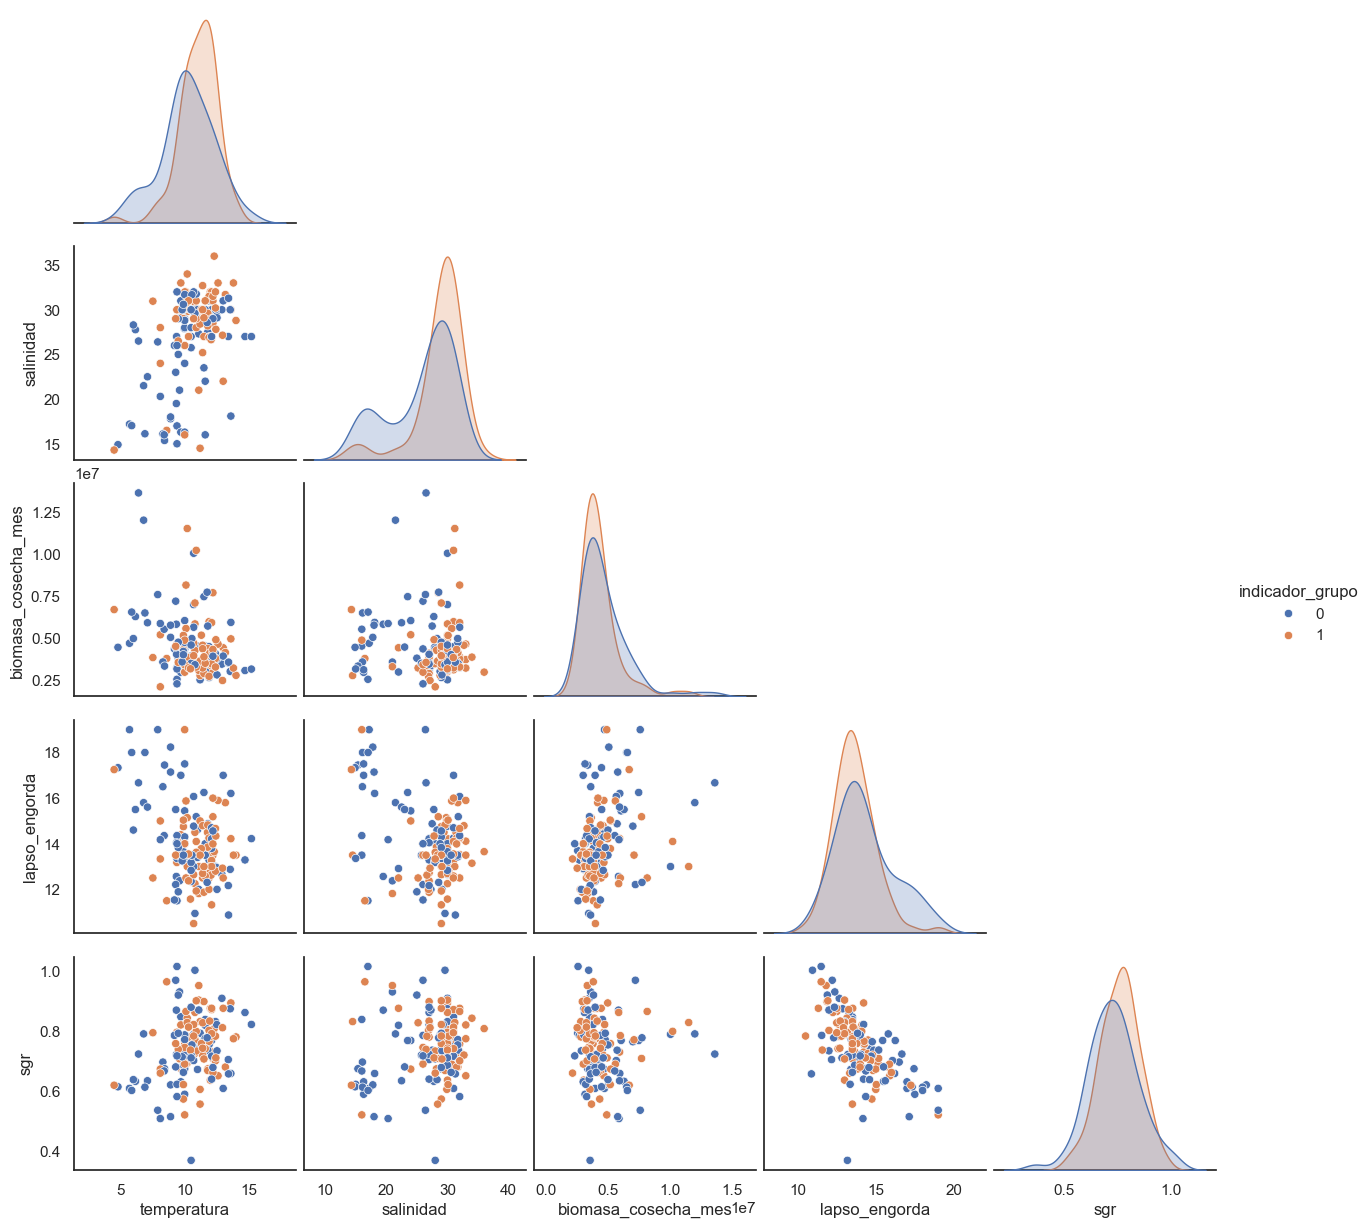

In [38]:
var_selec = selected_features.tolist()

sns.pairplot(base[var_selec + ["indicador_grupo"]], hue="indicador_grupo", corner=True)
plt.show()

In [47]:
selected_features.tolist()

['temperatura', 'salinidad', 'biomasa_cosecha_mes', 'lapso_engorda', 'sgr']

La figura anterior muestra gráficos de pares para un subconjunto de variables numéricas relevantes (biomasa de cosecha, factores de conversión, lapso de engorda, SGR, temperatura y salinidad), coloreadas según la categoría de daño branquial (indicador_grupo).

Las distribuciones marginales y los diagramas de dispersión sugieren diferencias sistemáticas entre los niveles de indicador_grupo, lo que indica que estas variables contienen información útil para discriminar entre branquias sanas, moderadas y graves.

In [48]:
x_colums = ["origen","agua_smolt","peso_cosecha","temperatura",
               "salinidad","estacion_ingreso","biomasa_cosecha_mes","peso_ingreso",
               "biomasa_ingreso_smolt","n_smolt_ingresados","fc_rb","lapso_engorda",
               "sgr","fc_re"]
y_column = ["indicador_grupo"]

In [49]:
#------------------------------ DEFINICION DE VARIABLES DEL MODELO --------------------------#
feat_cols = selected_features.tolist()
 
# Definimos la variable objetivo
target_col   = "indicador_grupo"    

# Las definimos dentro de nuestro dataframe
X = base[x_colums]
y = base[target_col]

In [50]:
#----------------------------- DEFINIMOS NUESTRO SET DE ENTRENAMIENTO Y PRUEBA -----------------------#

# Separamos los datos para el entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

feat_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
feat_categoricas = X.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", feat_numericas)
print("Categóricas:", feat_categoricas)

Numéricas: ['peso_cosecha', 'temperatura', 'salinidad', 'biomasa_cosecha_mes', 'peso_ingreso', 'biomasa_ingreso_smolt', 'n_smolt_ingresados', 'fc_rb', 'lapso_engorda', 'sgr', 'fc_re']
Categóricas: ['origen', 'agua_smolt', 'estacion_ingreso']


In [51]:
#------------------------------- CONTRUCCIÓN DEL PIPELINE -----------------------------------------------#

# Pipeline para numéricas
num_estandar = Pipeline(steps=[
    ("scaler", StandardScaler())])

# Pipeline para categóricas
cate_estandar = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# ColumnTransformer que aplica cada cosa donde corresponde
preprocessor = ColumnTransformer(
    transformers=[("num", num_estandar, feat_numericas),("cat", cate_estandar, feat_categoricas)])

# Clasificador base SVM
svm_clf = SVC(probability=False,random_state=42)

# Pipeline completo
svm_pipeline = Pipeline(steps=[("preprocess", preprocessor),("model", svm_clf)])


Se construyó un pipeline de preprocesamiento que estandariza las variables numéricas y codifica las categóricas mediante one-hot encoding. Estas transformaciones se integraron en un ColumnTransformer y posteriormente se combinaron con un clasificador SVM dentro de un pipeline completo, garantizando un flujo consistente de preprocesamiento y modelamiento.

In [52]:
param_grid = {
    "model__kernel": ["rbf","poly"], 
    "model__C": [0.01 ,0.1, 1, 10, 100,200,400], 
    "model__gamma": ["scale", 1, 0.1, 0.01, 0.001],
    "model__cache_size": [1000,1500],
    "model__class_weight":["balanced",{0:0.4,1:0.6},{0:0.5,1:0.5},{0:0.6,1:0.4},{0:0.45,1:0.55}]
}

grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=10,
    scoring="accuracy",
    n_jobs=-1)

grid_svm.fit(X_train, y_train)

print("Mejores parámetros:", grid_svm.best_params_)
print("Mejor accuracy CV:", grid_svm.best_score_)


Mejores parámetros: {'model__C': 200, 'model__cache_size': 1000, 'model__class_weight': {0: 0.45, 1: 0.55}, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Mejor accuracy CV: 0.6685897435897437


Accuracy en test: 0.5806451612903226

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.62      0.50      0.55        16
           1       0.56      0.67      0.61        15

    accuracy                           0.58        31
   macro avg       0.59      0.58      0.58        31
weighted avg       0.59      0.58      0.58        31



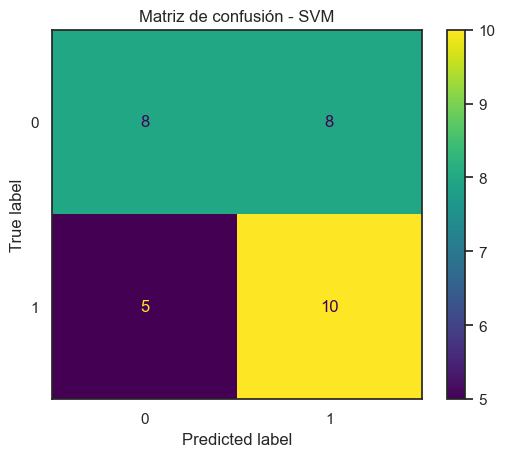

In [53]:
best_svm = grid_svm.best_estimator_
y_pred = best_svm.predict(X_test)

print("Accuracy en test:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test)
plt.title("Matriz de confusión - SVM")
plt.show()


In [54]:
report = classification_report(y_test, y_pred, output_dict=True)
tabla_resumen(report)

Métrica,Branquia no grave,Branquia grave,Descripción
Precisión (Precision),0.620000,0.560000,Proporción de predicciones correctas dentro de cada clase predicha.
Sensibilidad (Recall),0.500000,0.670000,Branquia grave: proporción de casos graves correctamente identificados.
F1-score,0.550000,0.610000,Media armónica entre precisión y recall.
Support,16,15,Número de observaciones reales en cada clase.
Accuracy global,-,-,0.580000


#### 5.6 Resultados y análisis

Dado que el objetivo principal del análisis es identificar correctamente los casos de branquia grave, la métrica más relevante es la sensibilidad de dicha clase. El modelo SVM alcanza un recall de **0.67** para la clase Grave, lo que indica que es capaz de detectar aproximadamente dos tercios de los casos positivos. Si bien este desempeño es superior al azar, aún deja un margen relevante de falsos negativos, lo cual puede ser crítico desde una perspectiva sanitaria, pues implica no identificar centros con daño branquial severo.

Por otro lado, la clase No grave presenta un recall de **0.50**, evidenciando que el modelo también tiene dificultades para clasificar de forma estable ambas categorías. Las métricas globales (accuracy = 0.58, F1-score promedio = 0.58) refuerzan la idea de que el modelo entrega un rendimiento moderado, sin lograr una separación clara entre clases.

En conjunto, el SVM evaluado ofrece un desempeño limitado para la clasificación temprana del estado branquial en este conjunto de datos. Si bien logra cierta capacidad de detección de casos graves, su precisión general es insuficiente para aplicaciones operativas, sugiriendo la necesidad de incorporar más información, ampliar el tamaño de muestra o explorar modelos alternativos que puedan capturar relaciones más complejas entre las variables.

#--------------------------------------------------------------------------------------------------------------------------------------------------#

### 6. Modelo Bayesiano 

El segundo enfoque evaluado corresponde a un clasificador Naive Bayes, un modelo probabilístico basado en el teorema de Bayes que estima la probabilidad de pertenecer a una clase a partir de la distribución de cada predictor. Su supuesto central es la independencia condicional entre variables, lo cual rara vez se cumple completamente en datos productivos y ambientales; sin embargo, este enfoque es ampliamente utilizado como línea base por su simplicidad, baja complejidad computacional y buen desempeño en conjuntos de datos pequeños.

En este estudio, Naive Bayes se incorpora como un modelo de referencia para contrastar el rendimiento de técnicas más complejas. Su estructura permite obtener interpretaciones directas sobre la contribución probabilística de cada predictor y ofrece un punto de comparación inicial para evaluar si algoritmos más avanzados —como SVM— proporcionan mejoras sustanciales en el problema de clasificación del estado branquial.

In [63]:
from pgmpy.models import DiscreteBayesianNetwork as BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from sklearn.naive_bayes import GaussianNB

In [64]:
param_grid_nb = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4,1e-3]
}
# Clasificador base Nb
GNB_clf = GaussianNB()

# Pipeline completo
GNB_pipeline = Pipeline(steps=[("preprocess", preprocessor),("model", GNB_clf)])

grid_nb = GridSearchCV(
    estimator=GNB_pipeline,
    param_grid=param_grid_nb,
    cv=10,
    scoring="accuracy",
    n_jobs=-1)

grid_nb.fit(X_train, y_train)

print("Mejores parámetros:", grid_nb.best_params_)
print("Mejor accuracy CV:", grid_nb.best_score_)


Mejores parámetros: {'model__var_smoothing': 0.001}
Mejor accuracy CV: 0.6019230769230768


In [65]:
grid_nb.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['peso_cosecha',
                                                   'temperatura', 'salinidad',
                                                   'biomasa_cosecha_mes',
                                                   'peso_ingreso',
                                                   'biomasa_ingreso_smolt',
                                                   'n_smolt_ingresados',
                                                   'fc_rb', 'lapso_engorda',
                                                   'sgr', 'fc_re']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['origen', 'agua_smolt',
                                                   'estacion_ingreso'])])),
                ('model', GaussianNB(var_smoothing=0.001))])

Accuracy en test: 0.6129032258064516

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.31      0.45        16
           1       0.56      0.93      0.70        15

    accuracy                           0.61        31
   macro avg       0.70      0.62      0.58        31
weighted avg       0.70      0.61      0.57        31



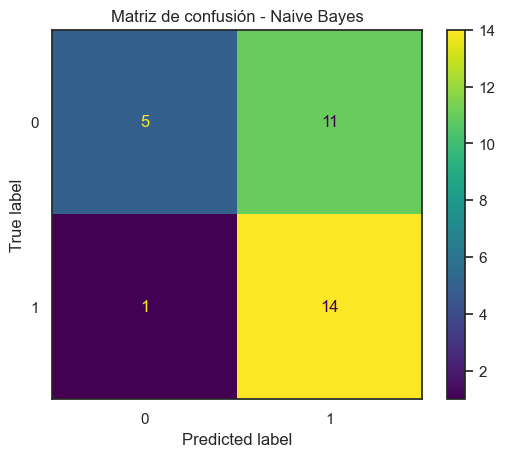

In [66]:
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test)

print("Accuracy en test:", accuracy_score(y_test, y_pred_nb))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_nb))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_nb, X_test, y_test)
plt.title("Matriz de confusión - Naive Bayes")
plt.show()


In [67]:
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
tabla_resumen(report_nb)

Métrica,Branquia no grave,Branquia grave,Descripción
Precisión (Precision),0.830000,0.560000,Proporción de predicciones correctas dentro de cada clase predicha.
Sensibilidad (Recall),0.310000,0.930000,Branquia grave: proporción de casos graves correctamente identificados.
F1-score,0.450000,0.700000,Media armónica entre precisión y recall.
Support,16,15,Número de observaciones reales en cada clase.
Accuracy global,-,-,0.610000


### 6.2 Resultados y análisis

El modelo Naive Bayes se incorporó como una línea base probabilística, asumiendo independencia condicional entre predictores. A pesar de ser un modelo simple, su desempeño fue competitivo, alcanzando una accuracy de **61%**, ligeramente superior al SVM. Su principal fortaleza fue la detección de casos de branquia grave, donde obtuvo un recall de **93%**, lo que implica que identifica correctamente la gran mayoría de los casos críticos. Sin embargo, este buen desempeño se logró a costa de una baja capacidad para clasificar adecuadamente los casos no graves (recall de **31%**), generando un número considerable de falsos positivos.

En conjunto, Naive Bayes ofrece una alternativa útil cuando la prioridad es minimizar falsos negativos en la clase grave, aunque con un menor equilibrio general entre clases. Su rol dentro del análisis es principalmente comparativo, para evaluar la ganancia obtenida frente a modelos más complejos.

#---------------------------------------------------------------------------------------------------------------------------------------------------#

### 7. .Modelo MLP

El tercer enfoque considerado corresponde a un modelo de Multilayer Perceptron (MLP), una red neuronal artificial de tipo feed-forward que permite capturar relaciones no lineales entre los predictores y la variable objetivo. A diferencia de los modelos lineales o probabilísticos, el MLP ajusta una función de clasificación mediante capas ocultas y transformaciones no lineales, lo que le otorga mayor capacidad expresiva para modelar patrones complejos presentes en los datos productivos y ambientales.

El entrenamiento del MLP se realiza a través del algoritmo de backpropagation, optimizando los pesos internos mediante métodos de descenso del gradiente. Para mejorar la estabilidad y evitar sobreajuste, este tipo de modelo requiere una cuidadosa selección de hiperparámetros —como el número de neuronas, la función de activación y la tasa de aprendizaje— además de una adecuada normalización de los predictores.

Dentro del presente estudio, el MLP se incorpora como un modelo de mayor flexibilidad en comparación con SVM y Naive Bayes, permitiendo evaluar si estructuras más profundas y no lineales entregan mejoras predictivas en la clasificación del daño branquial. Su inclusión complementa la comparación entre modelos simples, intermedios y complejos para determinar cuál estrategia ofrece la mejor relación entre desempeño y estabilidad en el conjunto de datos disponible

In [69]:
from sklearn.neural_network import MLPClassifier

### armamos un modelo base para comparar con nuestro modelo ajustado, solamente seteamos el estado aleatorio

In [70]:
mlp_clf = MLPClassifier(random_state=42)

mlp_pipeline = Pipeline(steps=[("preprocess", preprocessor),("model", mlp_clf)])
mlp_pipeline.fit(X_train,y_train)
y_pred_mlp = mlp_pipeline.predict(X_test)

c:\Users\gaboa\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy en test: 0.45161290322580644

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45        16
           1       0.44      0.47      0.45        15

    accuracy                           0.45        31
   macro avg       0.45      0.45      0.45        31
weighted avg       0.45      0.45      0.45        31



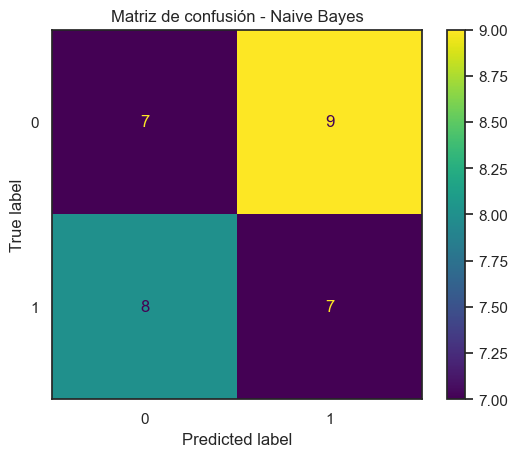

In [71]:
print("Accuracy en test:", accuracy_score(y_test, y_pred_mlp))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_mlp))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(mlp_pipeline, X_test, y_test)
plt.title("Matriz de confusión - Naive Bayes")
plt.show()

In [72]:
report_mlp_base = classification_report(y_test, y_pred_mlp, output_dict=True)
tabla_resumen(report_mlp_base)

Métrica,Branquia no grave,Branquia grave,Descripción
Precisión (Precision),0.470000,0.440000,Proporción de predicciones correctas dentro de cada clase predicha.
Sensibilidad (Recall),0.440000,0.470000,Branquia grave: proporción de casos graves correctamente identificados.
F1-score,0.450000,0.450000,Media armónica entre precisión y recall.
Support,16,15,Número de observaciones reales en cada clase.
Accuracy global,-,-,0.450000


### busqueda de hiperparametros

In [73]:
param_grid_mlp = {
    "model__hidden_layer_sizes" : [(100),(200),(300)],
    "model__activation" : ["relu","tanh"],
    "model__solver" : ["adam","sgd"],
    "model__alpha" : [1e-08,1e-07,],
    "model__batch_size" : [20,40],
    "model__learning_rate" : ['constant', "adaptive","invscaling"],
    "model__max_iter" : [200,500,700],
    "model__random_state" : [42] ,
    "model__tol" : [1e-04,1e-03,1e-02,1e-01],
    "model__validation_fraction" : [0.25,0.3,0.35],
    "model__epsilon" : [1e-08,1e-07,1e-06,]
    }

In [74]:
mlp_pipeline = Pipeline(steps=[("preprocess", preprocessor),("model", mlp_clf)])
grid_mlp = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid_mlp,
    cv=5,
    scoring="accuracy",
    n_jobs=-1)

grid_mlp.fit(X_train, y_train)

print("Mejores parámetros:", grid_mlp.best_params_)
print("Mejor accuracy CV:", grid_mlp.best_score_)

KeyboardInterrupt: 

In [ ]:
## mejores paramaretros para no volver a entrenar el modelo
# {'model__activation': 'tanh', 'model__alpha': 1e-08, 'model__batch_size': 20, 'model__epsilon': 1e-08, 'model__hidden_layer_sizes': 100, 'model__learning_rate': 'constant', 'model__max_iter': 700, 'model__random_state': 42, 'model__solver': 'sgd', 'model__tol': 0.0001, 'model__validation_fraction': 0.25

Accuracy en test: 0.6129032258064516

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.83      0.31      0.45        16
           1       0.56      0.93      0.70        15

    accuracy                           0.61        31
   macro avg       0.70      0.62      0.58        31
weighted avg       0.70      0.61      0.57        31



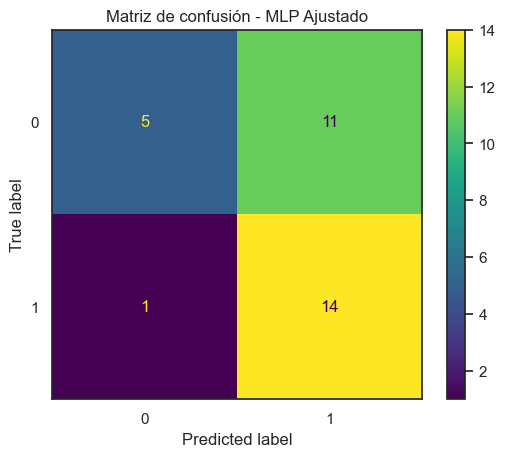

In [ ]:
best_mlp = grid_mlp.best_estimator_
y_pred_mlp_best = best_mlp.predict(X_test)

print("Accuracy en test:", accuracy_score(y_test, y_pred_mlp_best))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_mlp_best))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_mlp, X_test, y_test)
plt.title("Matriz de confusión - MLP Ajustado")
plt.show()

In [ ]:
best_mlp

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['peso_cosecha',
                                                   'temperatura', 'salinidad',
                                                   'biomasa_cosecha_mes',
                                                   'peso_ingreso',
                                                   'biomasa_ingreso_smolt',
                                                   'n_smolt_ingresados',
                                                   'fc_rb', 'lapso_engorda',
                                                   'sgr', 'fc_re']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['origen', 'agua_smolt',
                                                   'estacion_ingreso'])])),
                ('model',
                 MLPClassifier(activation='tanh', alpha=1e-08, batch_size=20,
                               hidden_layer_sizes=100, max_iter=700,
                               random_state=42, solver='sgd',
                               validation_fraction=0.25))])

In [ ]:
report_mlp_best = classification_report(y_test, y_pred_mlp_best, output_dict=True)
tabla_resumen(report_mlp_best)

Métrica,Branquia no grave,Branquia grave,Descripción
Precisión (Precision),0.830000,0.560000,Proporción de predicciones correctas dentro de cada clase predicha.
Sensibilidad (Recall),0.310000,0.930000,Branquia grave: proporción de casos graves correctamente identificados.
F1-score,0.450000,0.700000,Media armónica entre precisión y recall.
Support,16,15,Número de observaciones reales en cada clase.
Accuracy global,-,-,0.610000


#### 7.1 Resultados y análisis

El modelo Multilayer Perceptron (MLP) entrenado sobre el conjunto de datos obtuvo una accuracy de 61%, un rendimiento equivalente al observado en el modelo Naive Bayes. Sin embargo, la distribución de errores ofrece una lectura más matizada de su desempeño. Su principal fortaleza fue la detección de casos de branquia grave, alcanzando un recall de 93%, lo que significa que el modelo identifica correctamente casi todos los casos críticos. Esta característica es especialmente valiosa desde el punto de vista sanitario, ya que minimizar falsos negativos (casos graves clasificados como no graves) reduce riesgos operativos importantes.

No obstante, este resultado viene acompañado de una baja capacidad para reconocer adecuadamente los casos no graves, donde el modelo solo logró un recall de 31%. Esto implica que clasifica erróneamente muchos centros sin daño grave como si presentaran un problema, generando un número elevado de falsos positivos. La matriz de confusión evidencia este desequilibrio: de 16 casos no graves, solo 5 fueron clasificados correctamente, mientras que 11 fueron etiquetados como graves; en cambio, de 15 casos graves, 14 fueron detectados correctamente.

En conjunto, el MLP presenta un desempeño orientado a la detección exhaustiva de la clase grave, sacrificando especificidad a cambio de sensibilidad. Este comportamiento lo posiciona como un modelo útil para escenarios donde el objetivo es evitar subdiagnósticos de daño branquial, aunque introduce un nivel alto de alertas falsas que podría limitar su uso operativo sin un sistema complementario de validación.

#---------------------------------------------------------------------------------------------------------------------------------------------------#

### 8. Conclusiones generales del proyecto

En este estudio se evaluaron tres enfoques de clasificación —SVM, Naive Bayes y Multilayer Perceptron (MLP)— con el objetivo de predecir la presencia de daño branquial grave en centros de cultivo. Cada modelo presentó un balance distinto entre sensibilidad, especificidad y desempeño general, reflejando diferentes estrategias para abordar el problema.

En términos globales, los modelos lograron niveles de accuracy entre 58% y 61%, lo que indica un rendimiento moderado en un conjunto de datos de tamaño acotado y con variables de diversa naturaleza. Sin embargo, el análisis detallado muestra diferencias relevantes en la forma en que cada algoritmo distribuye sus errores.

1. SVM (58% accuracy) mostró un desempeño equilibrado pero sin destacar en la detección de casos graves; alcanzó un recall de 67% para la clase crítica, lo que implica un riesgo considerable de falsos negativos.

2. Naive Bayes (61% accuracy) presentó una marcada orientación a identificar casos de branquia grave, logrando un recall de 93%, aunque sacrificando especificidad. Su capacidad para clasificar correctamente los casos no graves fue limitada.

3. MLP (61% accuracy) reprodujo un patrón similar al modelo bayesiano: recall de 93% para la clase grave, pero una clasificación deficiente de la clase no grave, con un 31% de recall. Esto refleja una estrategia altamente enfocada en minimizar falsos negativos, aun a costa de generar numerosas alertas falsas.

En conjunto, los resultados evidencian un compromiso inherente entre sensibilidad y especificidad. Mientras los modelos simples (Naive Bayes) y no lineales (MLP) favorecen la detección exhaustiva de casos críticos, el SVM ofrece una separación más balanceada pero con menor efectividad para identificar la clase grave. La elección del modelo más adecuado dependerá del criterio operativo: si lo prioritario es evitar pasar por alto casos graves, Naive Bayes y MLP son superiores; si se requiere mayor equilibrio entre clases, el SVM resulta más conservador.

In [48]:
y_pred_nb

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [49]:
y_pred_mlp_best

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int64)